Reference: https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment-latest

In [1]:
import os
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoConfig
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import pandas as pd
from scipy.special import softmax

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
RAW_COMMENT_PATH = 'data_2018_2023/comments.csv'
RAW_POST_PATH = 'data_2018_2023/posts.csv'

CHARLIE_LABEL_PATH = 'manual/charlie_comments.csv'
DANIEL_LABEL_PATH = 'manual/daniel_comments.csv'
DILLAN_LABEL_PATH = 'manual/dillan_comments.csv'

COMMENT_OUTPUT_DIR = 'full_data_batch_label/labeled_comments'
POST_OUTPUT_DIR = 'full_data_batch_label/labeled_posts'

In [3]:
def make_prediction(batch_idx, text_idx, text, tokenizer, model):
    '''Acquire sentiment prediction for a single text.'''
    try:
        encoded_input = tokenizer(text, return_tensors='pt')
        output = model(**encoded_input)
        scores = output[0][0].detach().numpy()
        scores = softmax(scores)
        ranking = np.argsort(scores)
        ranking = ranking[::-1]
        pred_idx = np.argmax(scores)
    except:
        print('Failed to predict sentiment for batch %i text %i!' % (batch_idx, text_idx))
        return ('error', 0)
    
    return (config.id2label[pred_idx], scores[pred_idx])


def make_batch_prediction(batch_idx, output_filename, batch, tokenizer, model):
    '''Acquire sentiment prediction for a batch of texts'''
    text_list = list(batch.body)
    prediction_list = [make_prediction(batch_idx, text_idx, text, tokenizer, model) for text_idx, text in enumerate(text_list)]
    
    batch['predicted_label'] = [pair[0] for pair in prediction_list]
    batch['confidence'] = [pair[1] for pair in prediction_list]
    batch.to_csv(output_filename, index=False)
    
    print(batch.predicted_label.value_counts(normalize=True))

### Model setup

In [4]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
config = AutoConfig.from_pretrained(MODEL)

# PT
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [13]:
# Example prediction task

text = "bro relax"
encoded_input = tokenizer(text, return_tensors='pt')
output = model(**encoded_input)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
ranking = np.argsort(scores)
ranking = ranking[::-1]
scores

array([0.22169703, 0.6094966 , 0.1688064 ], dtype=float32)

In [14]:
for i in range(scores.shape[0]):
    l = config.id2label[ranking[i]]
    s = scores[ranking[i]]
    print(f"{i+1}) {l} {np.round(float(s), 4)}")

1) neutral 0.6095
2) negative 0.2217
3) positive 0.1688


### Input Data Setup
Load data for the main prediction task

In [7]:
# Predicting sentiment for the full dataset
main_comment_df = pd.read_csv(RAW_COMMENT_PATH)
main_post_df = pd.read_csv(RAW_POST_PATH)

main_comment_df.body = main_comment_df.body.fillna('')
main_post_df.title_text_combined = main_post_df.title_text_combined.fillna('')

# Rename the text field in post df to be consistent with comment df
main_post_df.rename({'title_text_combined': 'body'}, axis=1, inplace=True)

# Split into 40 or 4 batches as checkpoints to recover from interruptions
comment_batches = np.array_split(main_comment_df, 40)
post_batches = np.array_split(main_post_df, 4)

In [8]:
main_comment_df.head()

,idstr,created,parent,submission,body,score
0,t1_e57ddqc,2018-09-01 09:40:47,t1_e55e71k,t3_9bmgmx,this is maybe true but I'll still take a smell...,1.0
1,t1_e57gijd,2018-09-01 11:34:08,t3_9c2dxp,t3_9c2dxp,"It's not a big deal, just be respectful about ...",56.0
2,t1_e57ih7p,2018-09-01 12:28:47,t3_9c2dxp,t3_9c2dxp,They also record 280 lectures online so you ca...,17.0
3,t1_e57khfz,2018-09-01 13:13:55,t3_9c2dxp,t3_9c2dxp,"No, the principal will find out and put it on ...",90.0
4,t1_e57kio1,2018-09-01 13:14:36,t3_9c2dxp,t3_9c2dxp,May also want to let your prof know that you w...,12.0


Or load manually annotated subset for model validation

In [27]:
# Predicting sentiment for round 2 manual labels
charlie_label_df = pd.read_csv(CHARLIE_LABEL_PATH)
dillan_label_df = pd.read_csv(DILLAN_LABEL_PATH)
daniel_label_df = pd.read_csv(DANIEL_LABEL_PATH)

comparison = pd.DataFrame()
comparison['charlie_label'] = charlie_label_df.sentiment_label
comparison['dillan_label'] = dillan_label_df.sentiment_label
comparison['daniel_label'] = daniel_label_df.sentiment_label
comparison.head()

,charlie_label,dillan_label,daniel_label
0,1,1,1
1,-1,-1,-1
2,1,-1,1
3,1,1,-1
4,1,1,0


### Prediction Loop

#### 1. Manual label validation

In [28]:
validation_texts = charlie_label_df.body.fillna('')
comparison['body'] = validation_texts

output = [make_prediction(0, idx, text, tokenizer, model) for idx, text in enumerate(validation_texts)]
comparison['model_label'] = [pair[0] for pair in output]
comparison['model_label'] = comparison['model_label'].replace({'positive': 1, 'negative': -1, 'neutral': 0, 'error': 0})
comparison['model_confidence'] = [pair[1] for pair in output]
comparison.head()

Failed to predict sentiment for batch 0 text 310!


,charlie_label,dillan_label,daniel_label,body,model_label,model_confidence
0,1,1,1,congrats on passing!!!!!!! this is something t...,1,0.974098
1,-1,-1,-1,bro…relax,0,0.690845
2,1,-1,1,I had the same problem coming in as a freshman...,1,0.376017
3,1,1,-1,"Well, can’t give ya comfort because I think th...",0,0.558477
4,1,1,0,Grades don’t really matter. I graduated years ...,0,0.478843


In [9]:
# Counting the number of annotators that the model agrees with for each text
accuracy = (comparison.charlie_label == comparison.model_label).astype(int) + (comparison.dillan_label == comparison.model_label).astype(int) + (comparison.daniel_label == comparison.model_label.astype(str)).astype(int)
accuracy = pd.DataFrame(accuracy.value_counts()).reset_index()
accuracy.columns = ['level_of_match', 'number_of_match']
accuracy

,level_of_match,number_of_match
0,3,221
1,2,95
2,1,71
3,0,46


In [29]:
comparison.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 433 entries, 0 to 432
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   charlie_label     433 non-null    int64  
 1   dillan_label      433 non-null    int64  
 2   daniel_label      433 non-null    object 
 3   body              433 non-null    object 
 4   model_label       433 non-null    int64  
 5   model_confidence  433 non-null    float64
dtypes: float64(1), int64(3), object(2)
memory usage: 20.4+ KB


In [38]:
comparison.charlie_label = comparison.charlie_label.astype(str)
comparison.dillan_label = comparison.dillan_label.astype(str)
comparison.model_label = comparison.model_label.astype(str)
temp = comparison[comparison.charlie_label != comparison.dillan_label]
temp = temp[temp.charlie_label != temp.daniel_label]
temp = temp[temp.daniel_label != temp.dillan_label]
temp

,charlie_label,dillan_label,daniel_label,body,model_label,model_confidence,consensus
12,1,-1,0,"Same bro, just got an internship offer 2 days ...",1,0.827566,1
20,-1,0,1,By definition a C grade is passing and indicat...,1,0.856058,1
95,1,0,-1,Good. If we don’t respect not guilty verdicts...,-1,0.678503,-1
214,-1,1,0,Negative 60k? School for profit,0,0.577416,0
261,1,-1,0,"I wouldn’t say its super hard, I and many of m...",0,0.600051,0
267,1,-1,0,Dunno why ppl downvoted but yea u should defin...,0,0.565983,0
279,1,0,-1,He doesn't have debt anyway (I'm jealous) but ...,0,0.517729,0
402,1,-1,0,Someone in one of the /r/Michigan posts said a...,-1,0.663015,-1
417,-1,1,0,prof Beaumont apologized to the class today fo...,0,0.591617,0


In [39]:
def get_consensus(row):
    # Any form of majority vote
    if row.charlie_label == row.dillan_label:
        return row.charlie_label
    elif row.dillan_label == row.daniel_label:
        return row.dillan_label
    elif row.charlie_label == row.daniel_label:
        return row.daniel_label
    else:
        # Model takes a free win if none of us agree
        return row.model_label

In [40]:
comparison['consensus'] = comparison.apply(lambda r: get_consensus(r), axis=1)
comparison

,charlie_label,dillan_label,daniel_label,body,model_label,model_confidence,consensus
0,1,1,1,congrats on passing!!!!!!! this is something t...,1,0.974098,1
1,-1,-1,-1,bro…relax,0,0.690845,-1
2,1,-1,1,I had the same problem coming in as a freshman...,1,0.376017,1
3,1,1,-1,"Well, can’t give ya comfort because I think th...",0,0.558477,1
4,1,1,0,Grades don’t really matter. I graduated years ...,0,0.478843,1
...,...,...,...,...,...,...,...
428,0,1,0,"It wasn’t a hard assignment, I started at 10:3...",1,0.629152,0
429,1,1,1,Don’t be scared!!! If you can get through 280 ...,1,0.910908,1
430,-1,0,0,Just bomb that part of hw and it's just less t...,-1,0.693472,0
431,0,-1,0,"it takes 15 minutes to read the instructions, ...",-1,0.559133,0


In [41]:
comparison.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 433 entries, 0 to 432
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   charlie_label     433 non-null    object 
 1   dillan_label      433 non-null    object 
 2   daniel_label      433 non-null    object 
 3   body              433 non-null    object 
 4   model_label       433 non-null    object 
 5   model_confidence  433 non-null    float64
 6   consensus         433 non-null    object 
dtypes: float64(1), object(6)
memory usage: 23.8+ KB


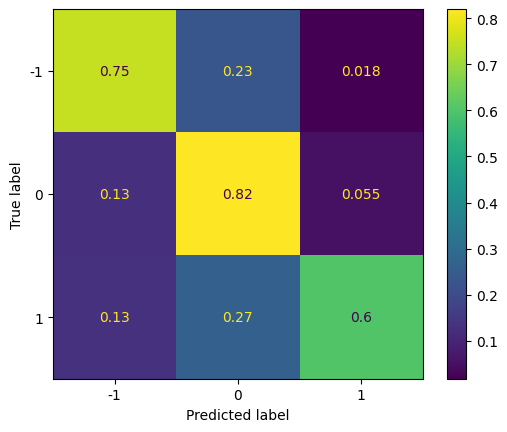

In [42]:
ConfusionMatrixDisplay.from_predictions(comparison.consensus, comparison.model_label, normalize='true')

<b>Validation Results
* Total number of observations: 433
* Percentage of model predictions that matches at least two human labels: 0.73
* Percentage of model predictions that matches at least one human label: 0.89

======================================================================================================
#### 2. Full dataset prediction

<b>Comments Sentiment Predictions
* Rough estimation of sentiment distribution: Neutral-50%, Positive-25%, Negative-25%, Error-0.1%

In [ ]:
for idx, batch in enumerate(comment_batches):
    output_filename = os.path.join(COMMENT_OUTPUT_DIR, 'batch_%i.csv' % idx)
    make_batch_prediction(idx, output_filename, batch, tokenizer, model)

<b>Posts Sentiment Predictions
* Rough estimation of sentiment distribution: Neutral-73%, Positive-9%, Negative-18%, Error-0.5%

In [ ]:
for idx, batch in enumerate(post_batches):
    output_filename = os.path.join(POST_OUTPUT_DIR, 'batch_%i.csv' % idx)
    make_batch_prediction(idx, output_filename, batch, tokenizer, model)